T1 spectrum

<xarray.Dataset> Size: 16kB
Dimensions:    (mixer: 2, z_voltage: 10, time: 100)
Coordinates:
  * mixer      (mixer) <U1 8B 'I' 'Q'
  * time       (time) int32 400B 16 416 816 1216 ... 38416 38816 39216 39616
  * z_voltage  (z_voltage) float64 80B 0.0 0.01 0.02 0.03 ... 0.07 0.08 0.09
Data variables:
    q2_ro      (mixer, z_voltage, time) float64 16kB ...
Attributes:
    z_offset:    -0.0592
    start_time:  20241127_113930
    end_time:    20241127_114002
4.823983466869626


[]

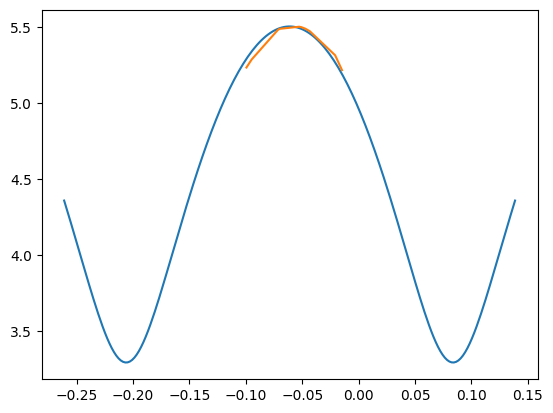

In [54]:
from numpy import array, std, average, round, max, min, transpose, abs, sqrt, cos, sin, pi, linspace, arange,ndarray, log10, ndarray, asarray
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt
import xarray as xr

# q0
# dataset = xr.open_dataset(r"D:\HW\Quela\QM\QM_data\Robert_sample\Robert_sample\good_result\q0\20241126_Data\20241126_152826_T1_spectrum\T1_spectrum.nc")
# zs = [0.1059, 0.0945, 0.0863, 0.0736, 0.0312, 0.0148, 0.0065, 0.0027]
# fqs = [5.651, 5.786, 5.855, 5.929, 5.912, 5.794, 5.711, 5.664]
# z_period = 0.36
# z_idle = 0.0505
# single_name = "q0_ro"

# q2
dataset = xr.open_dataset(r"D:\HW\Quela\QM\QM_data\Robert_sample\Robert_sample\good_result\q2\20241126_Data\20241127_114002_T1_spectrum\T1_spectrum.nc")
zs = [-0.0908-0.0087,-0.0861-0.0087,-0.0631-0.0087,-0.0615-0.0087, -0.044-0.0087,-0.042-0.0087,-0.0385-0.0087,-0.0345-0.0087,-0.0121-0.0087, -0.006-0.0087]
fqs = [5.2339,5.2872,5.4795,5.488, 5.502,5.499,5.489,5.472,5.3146, 5.2167]
z_period = 0.29
z_idle = -0.0612
single_name = "q2_ro"

print(dataset)

def set_fit_paras(): # **** manually set
    d = 0.6
    Ec = 0.3 #GHz
    Ej_sum = 25
    init = (Ec,Ej_sum,d)
    up_b = (0.31,50,1)
    lo_b = (0.29,10,0)

    return init, lo_b, up_b

def FqEqn(x,Ec,coefA,d):
    """
    a ~ period, b ~ offset, 
    """
    a = pi/z_period
    b = z_idle
    return sqrt(8*coefA*Ec*sqrt(cos(a*(x-b))**2+d**2*sin(a*(x-b))**2))-Ec

init, lo_b, up_b = set_fit_paras()

z = linspace(z_idle-0.2, z_idle+0.2, 200)
p, e = curve_fit(FqEqn,zs,fqs,p0=init,bounds=(lo_b,up_b))
fq_eq = FqEqn(z,*p)

fig, ax = plt.subplots()
ax.plot(z, fq_eq)
ax.plot(zs, fqs)
print(FqEqn(-0.13, *p))

plt.plot()


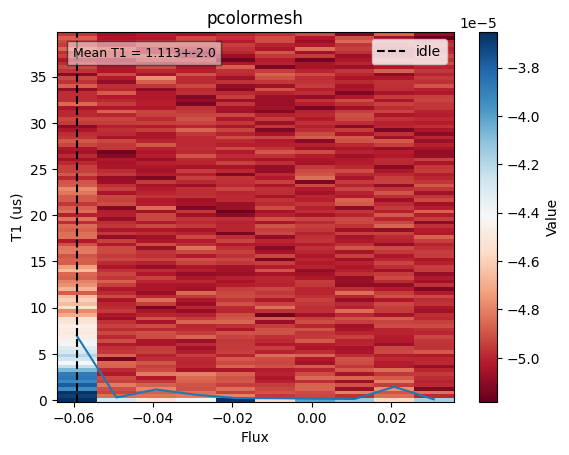

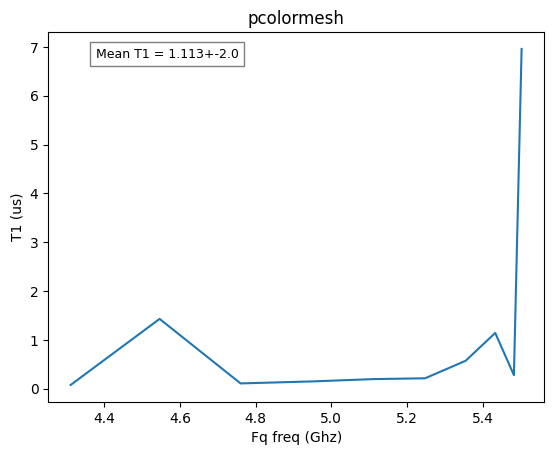

[6.95910893 0.27840002 1.1420845  0.57223326 0.21391779 0.19708975
 0.14973049 0.10853227 1.43011409 0.0778575 ]


ValueError: For X (0) and Y (101) with flat shading, A should have shape (100, -1, 3) or (100, -1, 4) or (100, -1) or (-100,), not (100, 0)

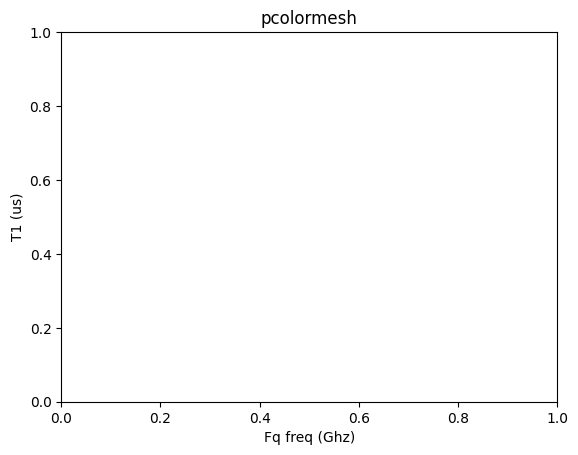

In [56]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from qcat.analysis.qubit.relaxation import qubit_relaxation_fitting

from numpy import sqrt, cos, sin, pi
from scipy.optimize import curve_fit

time = (dataset.coords["time"].values)/1000
z_voltage = dataset.coords["z_voltage"].values

def set_fit_paras(): # **** manually set
    d = 0.6
    Ec = 0.3 #GHz
    Ej_sum = 25
    init = (Ec,Ej_sum,d)
    up_b = (0.31,50,1)
    lo_b = (0.29,10,0)

    return init, lo_b, up_b

def FqEqn(x,Ec,coefA,d):
    """
    a ~ period, b ~ offset, 
    """

    a = pi/z_period
    b = z_idle
    return sqrt(8*coefA*Ec*sqrt(cos(a*(x-b))**2+d**2*sin(a*(x-b))**2))-Ec

init, lo_b, up_b = set_fit_paras()

p, e = curve_fit(FqEqn,zs,fqs,p0=init,bounds=(lo_b,up_b))
z = z_voltage+dataset.attrs["z_offset"]
fq_eq = FqEqn(z,*p)
fq_idle = FqEqn(z_idle,*p)



# dataset.data_vars.items()
for ro_name, data in [(single_name, dataset[single_name])]:
    acc_T1 = []
    for i in range(z_voltage.shape[-1]):
        fit_result = qubit_relaxation_fitting(time, data.values[0][i])
        acc_T1.append(fit_result.params["tau"].value)

    fig, ax = plt.subplots()
    ax.set_title('pcolormesh')
    ax.set_xlabel("Flux")
    ax.set_ylabel("T1 (us)")
    pcm = ax.pcolormesh(z,time, data.values[0].T, cmap='RdBu')# , vmin=z_min, vmax=z_max)
    ax.plot(z, acc_T1)
    ax.axvline(x=dataset.attrs["z_offset"], color='black', linestyle='--', label='idle')
    ax.text(0.04, 
            0.96, 
            f"Mean T1 = {np.mean(acc_T1):.4}+-{np.std(acc_T1):.2}",
            fontsize=9, 
            color="black",
            ha='left', 
            va='top',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5))
    ax.legend()
    
    plt.colorbar(pcm, label='Value')
    plt.show()
    
    
    
    fig, ax2 = plt.subplots()
    ax2.set_title('pcolormesh')
    ax2.set_xlabel("Fq freq (Ghz)")
    ax2.set_ylabel("T1 (us)")
    ax2.plot(fq_eq, acc_T1)
    ax2.text(0.04, 
            0.96, 
            f"Mean T1 = {np.mean(acc_T1):.4}+-{np.std(acc_T1):.2}",
            fontsize=9, 
            color="black",
            ha='left', 
            va='top',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()
    
    
    mask = (z <= z_idle)
    z_filtered = z[mask]
    data.values[0] = np.array(data.values[0])
    data_filtered = data.values[0][mask,:]
    fq_eq_filtered = FqEqn(z_filtered,*p)
    acc_T1 = np.array(acc_T1)
    acc_T1_filtered = acc_T1[mask]
    print(acc_T1)
    
    fig, ax3 = plt.subplots()
    ax3.set_title('pcolormesh')
    ax3.set_xlabel("Fq freq (Ghz)")
    ax3.set_ylabel("T1 (us)")
    pcm = ax3.pcolormesh(fq_eq_filtered,time, data_filtered.T, cmap='RdBu')# , vmin=z_min, vmax=z_max)
    ax3.plot(fq_eq_filtered, acc_T1_filtered)
    ax3.text(0.04, 
            0.96, 
            f"Mean T1 = {np.mean(acc_T1):.4}+-{np.std(acc_T1):.2}",
            fontsize=9, 
            color="black",
            ha='left', 
            va='top',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5))
    
    plt.colorbar(pcm, label='Value')
    plt.show()



# T1 spectrum rep

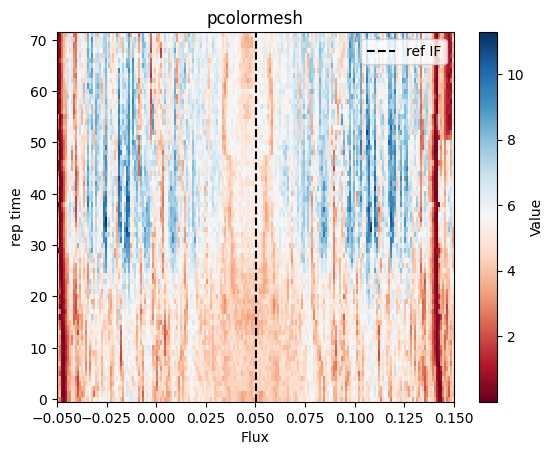

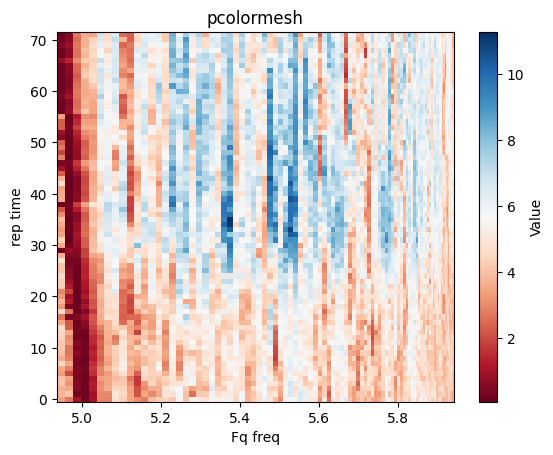

In [51]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os

from qcat.visualization.qubit_relaxation import plot_and_save_T1_spectrum_rep
from qcat.analysis.qubit.relaxation import qubit_relaxation_fitting

from numpy import sqrt, cos, sin, pi
from scipy.optimize import curve_fit 

# q0
dataset_rep = xr.open_dataset(r"D:\HW\Quela\QM\QM_data\Robert_sample\Robert_sample\good_result\q0\20241126_Data\20241127_051222_T1_spectrum_rep\T1_spectrum_rep.nc")

# q2
# dataset_rep = xr.open_dataset(r"D:\HW\Quela\QM\QM_data\Robert_sample\Robert_sample\good_result\q2\20241126_Data\20241126_163713_T1_spectrum\T1_spectrum.nc")

time = (dataset_rep.coords["time"].values)/1000
z_voltage = dataset_rep.coords["z_voltage"].values
rep = dataset_rep.coords["repetition"].values

def set_fit_paras(): # **** manually set
    d = 0.6
    Ec = 0.3 #GHz
    Ej_sum = 25
    init = (Ec,Ej_sum,d)
    up_b = (0.31,50,1)
    lo_b = (0.29,10,0)

    return init, lo_b, up_b

def FqEqn(x,Ec,coefA,d):
    """
    a ~ period, b ~ offset, 
    """
    z_period = 0.4
    a = pi/z_period
    b = z_idle
    return sqrt(8*coefA*Ec*sqrt(cos(a*(x-b))**2+d**2*sin(a*(x-b))**2))-Ec

init, lo_b, up_b = set_fit_paras()

p, e = curve_fit(FqEqn,zs,fqs,p0=init,bounds=(lo_b,up_b))
z = z_voltage+dataset_rep.attrs["z_offset"]
fq_eq = FqEqn(z,*p)
fq_idle = FqEqn(z_idle,*p)

# dataset.data_vars.items()
for ro_name, data in [(single_name, dataset_rep[single_name])]:
    acc_T1 = []
    for i in range(rep.shape[-1]):
        acc_T1.append([])
        for j in range(z_voltage.shape[-1]):
            fit_result = qubit_relaxation_fitting(time, data.values[i][0][j])
            acc_T1[i].append(fit_result.params["tau"].value)
    fig, ax = plt.subplots()
    ax.set_title('pcolormesh')
    ax.set_xlabel("Flux")
    ax.set_ylabel("rep time")
    pcm = ax.pcolormesh(z,rep, acc_T1, cmap='RdBu')# , vmin=z_min, vmax=z_max)
    ax.axvline(x=dataset_rep.attrs["z_offset"], color='black', linestyle='--', label='ref IF')
    ax.legend()
    
    plt.colorbar(pcm, label='Value')
    plt.show()
    
    
    mask = (z <= z_idle)
    z_filtered = z[mask]
    fq_eq_filtered = FqEqn(z_filtered,*p)
    acc_T1 = np.array(acc_T1)
    acc_T1_filtered = acc_T1[:,mask]
    
    fig, ax2 = plt.subplots()
    ax2.set_title('pcolormesh')
    ax2.set_xlabel("Fq freq")
    ax2.set_ylabel("rep time")
    pcm = ax2.pcolormesh(fq_eq_filtered,rep, acc_T1_filtered, cmap='RdBu')# , vmin=z_min, vmax=z_max)
    
    plt.colorbar(pcm, label='Value')
    plt.show()

